# Enhancement
We'll see how to improve the image quality using filtering and deconvolution

In [ ]:
%cd  C:\Users\jeromeb\Documents\GitHub\Analysis-of-Microscopy-Images-in-Python\examples

In [1]:
import tifffile
import numpy as np

filename = '../data/example.tif'
img = tifffile.imread(filename)
print("The shape of the array is [depth x channels x height x width]", img.shape)

The shape of the array is [depth x channels x height x width] (25, 2, 400, 400)


In [5]:
from skimage import filters
import napari

smoothed = img
smoothed[0,:,:,:] = filters.gaussian(img[0,:,:,:], 10)
smoothed[1,:,:,:] = filters.gaussian(img[1,:,:,:], 10)

# create a Viewer and add an image here with the two channels and scaling
with napari.gui_qt():

    napari.view_image(smoothed,channel_axis=1,name=['dapi', 'fitc'],scale=[10,1,1])

## Background substraction using the rolling ball algorithm
The rolling ball algorithm was introduced in Sternberg S. Biomedical Image Processing, IEEE Computer 1983;16(1):22-34. (DOI:10.1109/MC.1983.1654163)
This is not ideal for quantitative measurement of intensities but can help segment the image. This example is inspired from https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_rolling_ball.html

First, let's define first a function to help display the image, background and corrected image:

In [71]:
import matplotlib.pyplot as plt
from skimage.exposure import histogram
import numpy as np

def plt_bg_corr(im,bg,corrected):
    ''' Display background correction results '''
    fig, ax = plt.subplots(1, 4)
    ax[0].imshow(im,cmap='gray')
    ax[0].set_title('Image')
    ax[1].imshow(bg,cmap='gray')
    ax[1].set_title('Background')
    ax[2].imshow(corrected,cmap='gray')
    ax[2].set_title('Corrected')
    hist1, hist_centers1  = histogram(im)
    ax[3].loglog(hist_centers1, hist1, lw=2, label='before')
    hist2, hist_centers2  = histogram(corrected)
    ax[3].loglog(hist_centers2, hist2, lw=2,label='after')
    ax[3].set_title('Histogram')
    ax[3].set_position([0.75, -0.5, 0.25, 1])
    ax[3].legend()
    ax[3].set_xlabel('intensity (log)')

    for a in ax:
        a.set_axis_off()

    fig.tight_layout()



Let's load a test image too

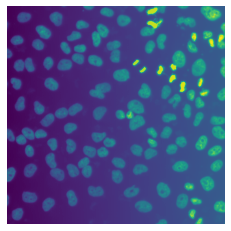

In [45]:
from skimage import io
import numpy as np
im = io.imread('../data/nuclei.tif')
im = im[0:500,0:500]
N,M = im.shape
Y,X = np.ix_(np.arange(N),np.arange(M))
# We add a bias defined as X/5 and convert the elements of the array to 16 bit unsiged integers.
im = np.asarray(im + X/5, dtype=np.uint16)
plt.imshow(im)
plt.axis('off')
plt.show()

Elapsed time: 3.52 s


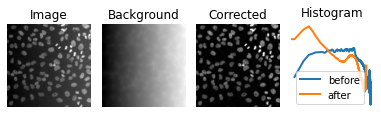

In [72]:
from skimage import restoration
from timeit import default_timer as timer

tic = timer()

# Apply a rolling ball to estimate a background image
bg = restoration.rolling_ball(im, radius=60)

# Substract the background to the image 
corrected = im - bg

# Display the image, the estimated background and the corrected image
plt_bg_corr(im,bg,corrected)

# Display elapsed time for this step
etime = timer() - tic
print(f"Elapsed time: {etime:.2f} s")


We might be unhappy with the results as the intensity and spatial dimension of the rolling ball are here linked. To decouple them, we can specify a kernel:

Elapsed time: 3.59 s


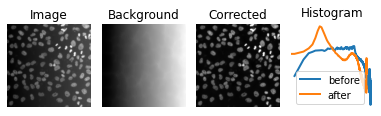

In [73]:
from skimage import restoration
from timeit import default_timer as timer

tic = timer()

# define a kernel for the rolling ball with its shape and intensity
kernel = restoration.ellipsoid_kernel((120,120),  10)

# Apply a rolling ball to estimate a background image
bg = restoration.rolling_ball(im, kernel=kernel)

# Substract the background to the image 
corrected = im - bg

# Display the image, the estimated background and the corrected image
plt_bg_corr(im,bg,corrected)

# Display elapsed time for this step
etime = timer() - tic
print(f"Elapsed time: {etime:.2f} s")

## Background substraction using a top-hat
The top-hat transform is defined as the difference between the image and it's morphological opening. The morphological opening of an image can be defined as a minimum filter or morphological erosion followed by a maximum filter or morphological dilation.

Elapsed time: 3.20 s
Elapsed time: 0.77 s


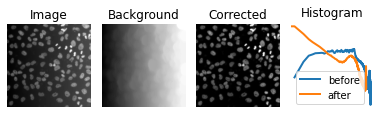

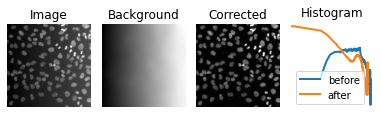

In [74]:
from skimage import morphology
from skimage.filters.rank import maximum, minimum
from skimage.filters import gaussian
from timeit import default_timer as timer

# We define a structuring element (flat kernel) with radius 30
selem =  morphology.disk(30)

tic = timer()
# We can either directly compute the corrected image
corrected = morphology.white_tophat(im, selem)

# and deduce the background.
bg = im - corrected

# Display the image, the estimated background and the corrected image
plt_bg_corr(im,bg,corrected)

# Display elapsed time for this step
etime = timer() - tic
print(f"Elapsed time: {etime:.2f} s")

# Let's test the same by coding directly the Top-Hat function
tic = timer()

# Define the erosion
bg2 = maximum(minimum(im, selem), selem)

# We can post process the background 
bg2 = gaussian(np.asarray(bg2,dtype=np.float), 20)

# Compute the residuals to obtain the top-hat
corrected2 = np.asarray(im,dtype=np.float)  - bg2

# Display again the results and timing
plt_bg_corr(im,bg2,corrected2)
etime = timer() - tic
print(f"Elapsed time: {etime:.2f} s")
